In [63]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [64]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from tqdm.notebook import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt

!pip install nilearn
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting

labels = np.load("MyDrive/labels.npy")
tensors = np.load("MyDrive/tensors.npy")


In [ ]:
!nvidia-smi

Sat Mar 27 00:34:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
ds = TensorDataset(torch.Tensor(tensors[:, None]), torch.Tensor(labels))
loader = DataLoader(ds, batch_size=16)

In [ ]:
class AutoEncoder3d(nn.Module):
  def __init__(self, hidden_dim=256):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv3d(1, 64, kernel_size=3, padding=1), #58, 70, 58
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), #29, 35, 29
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), #14, 17, 14
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), #7, 8, 7
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.MaxPool3d(2), #3, 4, 3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Conv3d(64, hidden_dim, kernel_size=3, padding=1), # 3, 4, 3
        nn.AdaptiveAvgPool3d((1, 1, 1)),
        nn.Flatten()
    )

    self.decoder = nn.Sequential(
        nn.Unflatten(1, (hidden_dim, 1, 1, 1)), # 1x1x1
        nn.Upsample(size=(3, 4, 3), mode='trilinear',), #3x4x3
        nn.Conv3d(hidden_dim, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(7, 8, 7), mode='trilinear'), #3x4x3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(14, 17, 14), mode='trilinear'), #3x4x3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(29, 35, 29), mode='trilinear'), #3x4x3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Upsample(size=(58, 70, 58), mode='trilinear'), #3x4x3
        nn.Conv3d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm3d(64),
        nn.Conv3d(64, 1, kernel_size=3, padding=1)
    )
  def forward(self, X):
    x = self.encoder(X)
    return self.decoder(x)


In [ ]:
model =  AutoEncoder3d().cuda()
model.load_state_dict(torch.load('MyDrive/AE_shibalda.pth'))

<All keys matched successfully>

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
crit = nn.MSELoss()

2857.0439453125


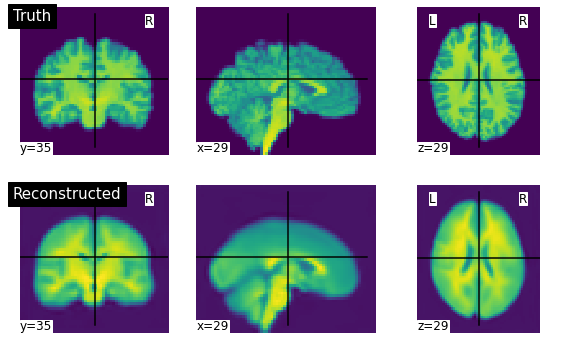

KeyboardInterrupt: ignored

In [ ]:
for e in range(10):
  for i, (X, y) in enumerate(loader):
    X = X.cuda() 
    y = y.cuda()
    
    pred = model(X)
    loss = crit(pred, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%20 == 0:
      clear_output()
      print(loss.item())
      affine = np.diag([1, 1, 1, 1])
      t1 = nib.Nifti1Image(X[0][0].detach().cpu().numpy(), affine)
      t2 = nib.Nifti1Image(pred[0][0].detach().cpu().numpy(), affine)
      f = plt.figure(figsize=(10,6))
      ax = plt.subplot(2, 1, 1)
      plotting.plot_img(t1, [s/2 for s in t1.shape], title="Truth", axes=ax)
      ax = plt.subplot(2, 1, 2)
      plotting.plot_img(t2, [s/2 for s in t2.shape], title="Reconstructed", axes=ax)

      plt.show()



In [ ]:
model.cpu()

AutoEncoder3d(
  (encoder): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): ReLU()
    (6): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): ReLU()
    (10): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (13): ReLU()
    (14): BatchNorm3d(64, eps=1e-05, m

In [ ]:
latent_space = []
for i in tqdm(range(tensors.shape[0])):
  lt_space = model.encoder(tensors[i,None])
  latent_space.append(lt_space.detach().numpy().flatten())
  del lt_space
latent_space = np.array(latent_space)
np.save("MyDrive/latent_space_ae.npy",latent_space)

In [ ]:
latent_space = np.load("MyDrive/latent_space_ae.npy")

In [ ]:
# Split data to train and test
split = 0.7
split = int(split*labels.shape[0])
idx = np.random.choice(labels.shape[0], labels.shape[0], replace=False).astype(int)
latent_space_train, latent_space_test = latent_space[idx[:split]], latent_space[idx[split:]]  
labels_train, labels_test = labels[idx[:split]], labels[idx[split:]]

F1 Score Train: 0.9471506980330642

F1 Score Test: 0.9107536095677733



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


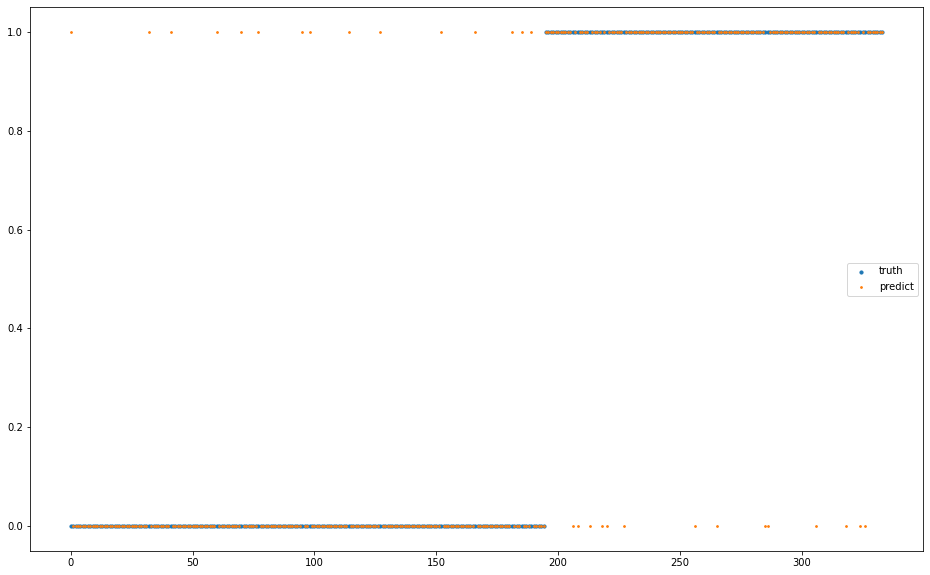

In [ ]:
# Train a regressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
def rmse(model ,X,y):
  return np.sqrt(((model.predict(X)- y)**2).mean())

#Train
reg = LogisticRegression(max_iter=200).fit(latent_space_train, labels_train)
print('F1 Score Train: {}'.format(f1_score(reg.predict(latent_space_train)[:, None], labels_train, average='macro')))
print()
print('F1 Score Test: {}'.format(f1_score(reg.predict(latent_space_test)[:, None], labels_test, average='macro')))
print()
plt.figure(figsize=(16,10))
lim = np.arange(labels_test.shape[0])
idx = np.argsort(labels_test)
plt.scatter(lim,labels_test[idx], s=10,label='truth')
plt.scatter(lim,reg.predict(latent_space_test)[idx], s=3, label='predict')
plt.legend()

Woman - 0
Man - 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



Ineration: [1]  alpha: 0.000

Ineration: [2]  alpha: 0.100

Ineration: [3]  alpha: 0.200


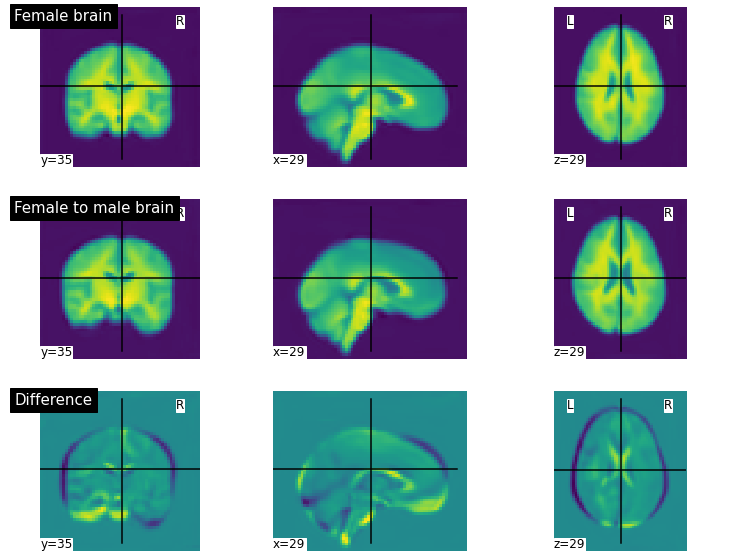

In [ ]:
images = []
weights = reg.coef_
for i in range(3):
  latent_space_woman = latent_space[69]
  latent_new = latent_space_woman + weights*(100000*i)
  latent_space_woman = torch.Tensor(latent_space_woman[None,])
  latent_new = torch.Tensor(latent_new)
  woman = model.decoder(latent_space_woman)
  man_rec = model.decoder(latent_new)
  print()
  print(f'Ineration: [{i+1}]  alpha: {0.1*i:.3f}')
  affine = np.diag([1, 1, 1, 1])
  t2 = nib.Nifti1Image(man_rec[0][0].detach().numpy(), affine)
  if i == 2:
    t2 = nib.Nifti1Image((woman[0][0]-man_rec[0][0]).detach().numpy(), affine)
  images.append(t2)

t = nib.Nifti1Image(tensors[0], affine)
f = plt.figure(figsize=(13,10))
ax = plt.subplot(3, 1, 1)
plotting.plot_img(images[0], [s/2 for s in tensors.shape[1:]], title="Female brain", axes=ax)
ax = plt.subplot(3, 1, 2)
plotting.plot_img(images[1], [s/2 for s in tensors.shape[1:]], title="Female to male brain", axes=ax)
ax = plt.subplot(3, 1, 3)
plotting.plot_img(images[2], [s/2 for s in tensors.shape[1:]], title="Difference", axes=ax)
